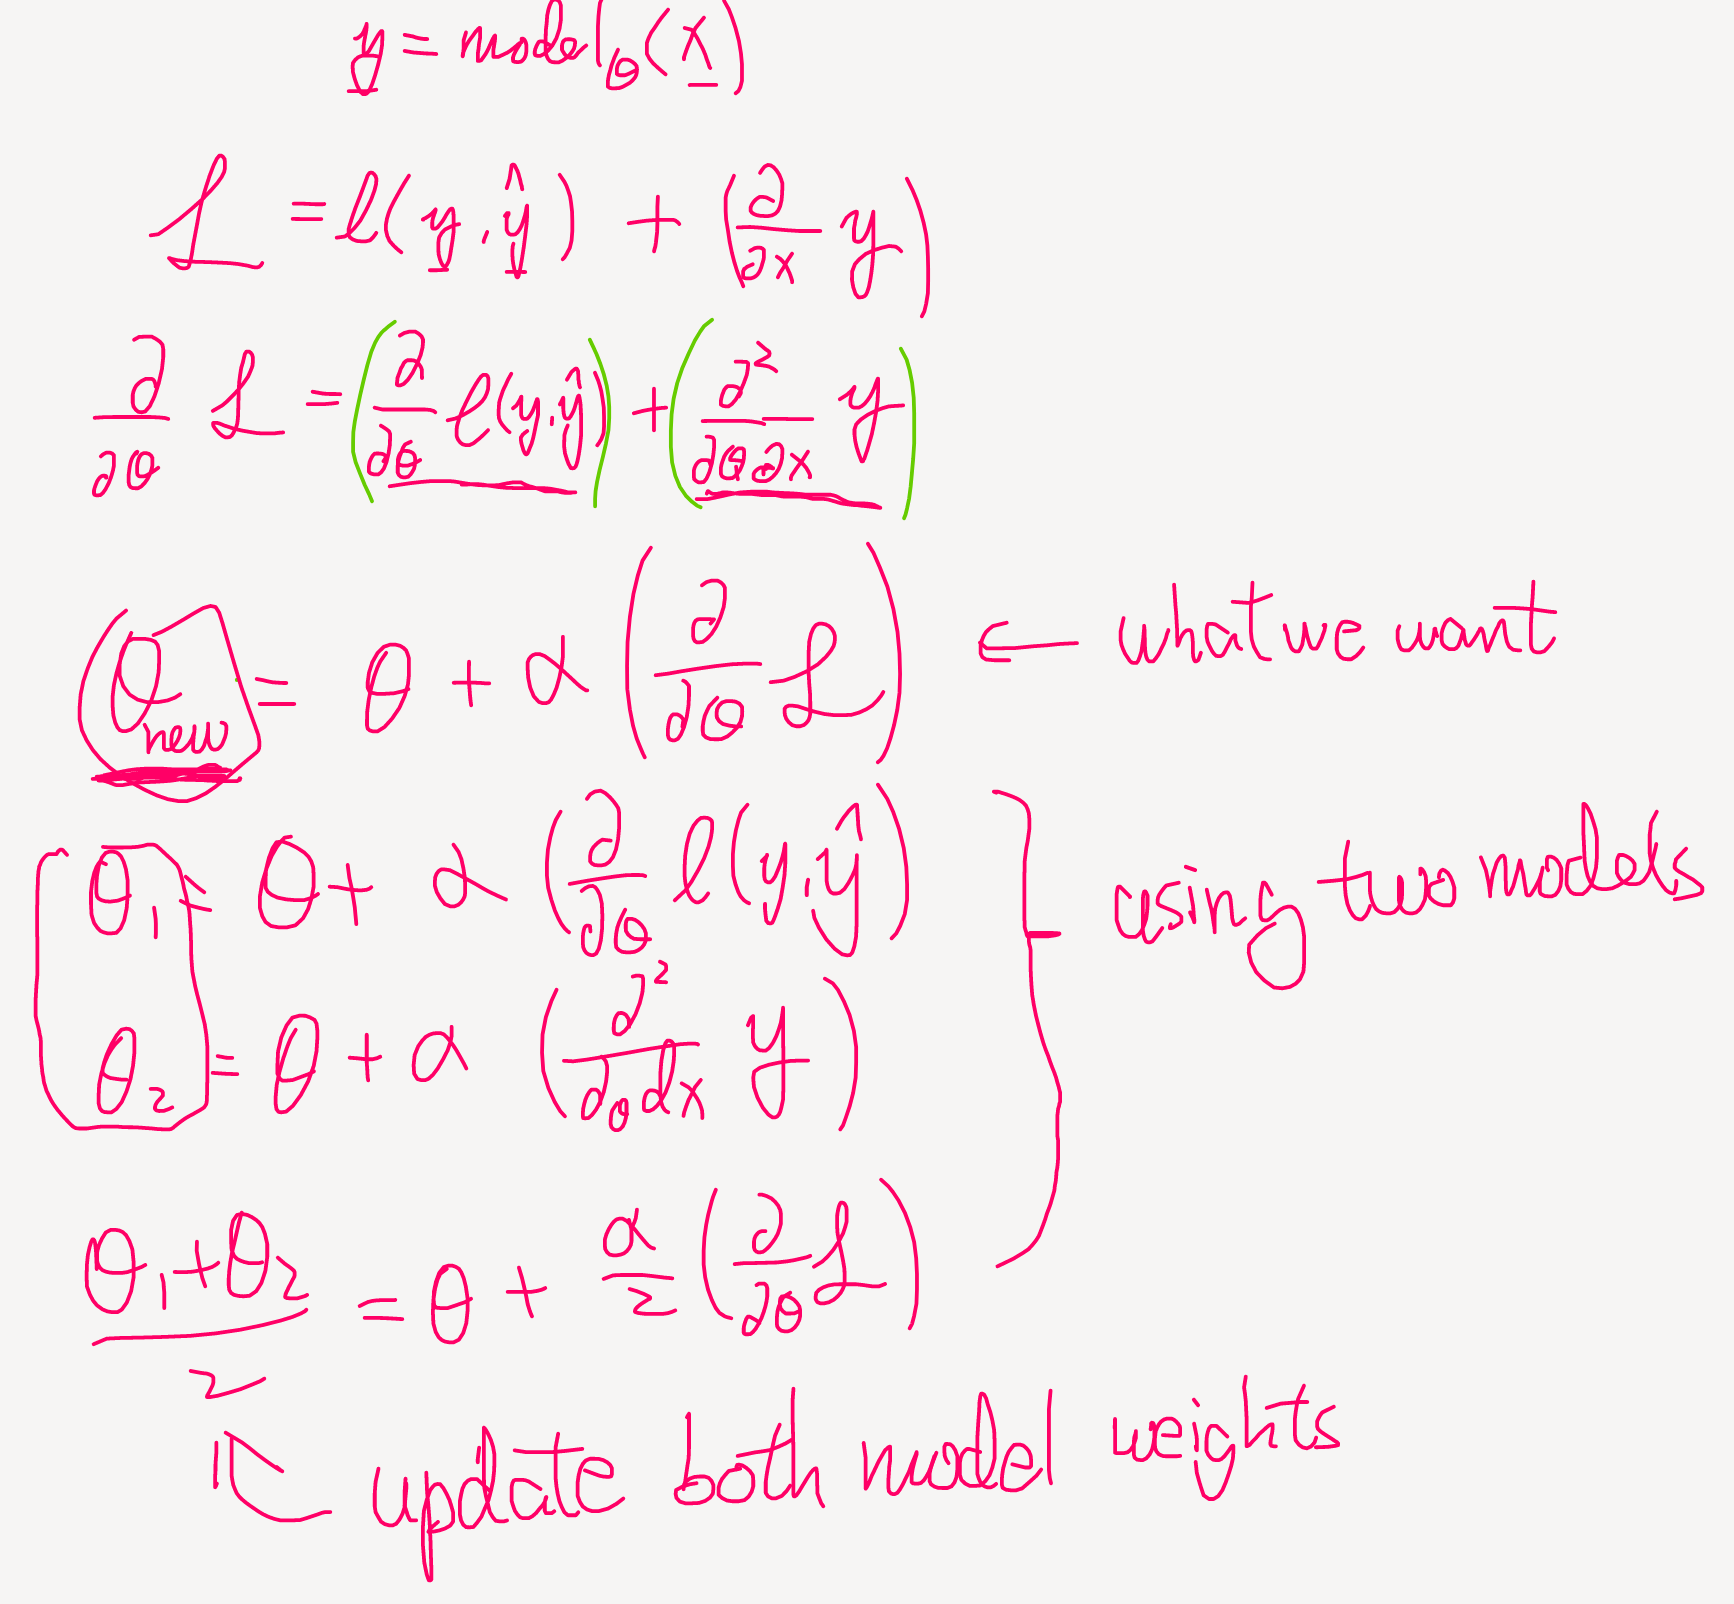

In [38]:
import os
import pickle
import numpy as np
import torch
from tqdm.notebook import tqdm

In [39]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.register_parameter(
            name='param',
            param=torch.nn.Parameter(torch.tensor([1., 2., 3.]))
        )
    
    def forward(self, x):
        return x**2 * self.param

In [40]:
from captum.attr import IntegratedGradients

In [52]:
model1 = Model()
model2 = Model()
model3 = model1.forward

In [53]:
model2.load_state_dict(model1.state_dict())

<All keys matched successfully>

In [54]:
# Need to update parameters from both models
optim = torch.optim.SGD(
    list(model1.parameters()) + list(model2.parameters()), lr=0.1)

In [55]:
x = torch.tensor([1., 1., 1.], requires_grad=True)

In [56]:
y = model1(x)
y

tensor([1., 2., 3.], grad_fn=<MulBackward0>)

In [57]:
target = 0

# ig = IntegratedGradients(model3)
# attribution = ig.attribute(
#     x,
#     torch.tensor([[0., 0., 0.]]), #, requires_grad=True
#     target=target
# )

# print(attribution)

n_iters = 51
attributions = torch.zeros(n_iters,3)
for i, alpha in enumerate(reversed(np.linspace(1, 0, num=n_iters, endpoint=True))):
    x_i = alpha * x
#     print(x_i)
    attributions[i] = torch.autograd.grad(model3(x_i)[target], x_i, create_graph=True)[0]
attribution = torch.mean(attributions, axis=0)
attribution = attribution * x

print(attribution)

tensor([1., 0., 0.], grad_fn=<MulBackward0>)


In [58]:
loss = torch.mean( y**2 )# + 200*attribution.sum()
loss

tensor(4.6667, grad_fn=<MeanBackward0>)

In [59]:
loss.backward()

In [60]:
optim.step()

In [61]:
# Model 1 and model 2 params should be updated but different
print(f'Model 1 param: {model1.param}')
print(f'Model 2 param: {model2.param}')

Model 1 param: Parameter containing:
tensor([0.9333, 1.8667, 2.8000], requires_grad=True)
Model 2 param: Parameter containing:
tensor([1., 2., 3.], requires_grad=True)


In [14]:
# To get the final parameter, simply average the parameters from both models
model1_param = model1.param.data
model2_param = model2.param.data
model1.param.data = (model1_param + model2_param)/2
model2.param.data = (model1_param + model2_param)/2

In [15]:
# Now they are the same
print(f'Model 1 param: {model1.param}')
print(f'Model 2 param: {model2.param}')

Model 1 param: Parameter containing:
tensor([0.9583, 1.9667, 2.9500], requires_grad=True)
Model 2 param: Parameter containing:
tensor([0.9583, 1.9667, 2.9500], requires_grad=True)


## Experiment with some FC models

In [28]:
import os
import pickle
import numpy as np
import torch
from tqdm.notebook import tqdm
from torch import nn
from captum.attr import IntegratedGradients

In [29]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight.data, 0.2)
        nn.init.constant_(m.bias.data, 0.2)

In [30]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden1 = nn.Linear(2, 2)
        self.hidden2 = nn.Linear(2, 3)
        self.hidden3 = nn.Linear(3, 3)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(3, 2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden2(self.hidden1(x))
        x = self.hidden3(x)
        x = self.output(x)
        return x
    
    def forward_v2(self, x):
        x = self.hidden3(x)
        x = self.output(x)
        return x

In [31]:
class Network2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden3 = nn.Linear(3, 3)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(3, 2)
    
    def forward(self, x):
        x = self.hidden3(x)
        x = self.output(x)
        return x

In [32]:
model1 = Network()
model1.apply(weights_init)
model2 = Network2()
model2.load_state_dict(model1.state_dict(), strict=False)
model3 = model1.forward_v2

ig = IntegratedGradients(model3)

In [33]:
for name, param in model1.named_parameters():
    if param.requires_grad:
        print ("{} , {}".format(name, param.data))

hidden1.weight , tensor([[0.2000, 0.2000],
        [0.2000, 0.2000]])
hidden1.bias , tensor([0.2000, 0.2000])
hidden2.weight , tensor([[0.2000, 0.2000],
        [0.2000, 0.2000],
        [0.2000, 0.2000]])
hidden2.bias , tensor([0.2000, 0.2000, 0.2000])
hidden3.weight , tensor([[0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000]])
hidden3.bias , tensor([0.2000, 0.2000, 0.2000])
output.weight , tensor([[0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000]])
output.bias , tensor([0.2000, 0.2000])


In [34]:
for name, param in model2.named_parameters():
    if param.requires_grad:
        print ("{} , {}".format(name, param.data))

hidden3.weight , tensor([[0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000]])
hidden3.bias , tensor([0.2000, 0.2000, 0.2000])
output.weight , tensor([[0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000]])
output.bias , tensor([0.2000, 0.2000])


In [35]:
for name, param in model3.named_parameters():
    if param.requires_grad:
        print ("{} , {}".format(name, param.data))

AttributeError: 'function' object has no attribute 'named_parameters'

In [36]:
X_train = torch.tensor([20., 90.], requires_grad=True)
y_train = torch.tensor([1., 2.])
lambda_ = 200000 # multiplication factor for the attr_loss

In [37]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01)
optimizer_partial = torch.optim.SGD(model2.parameters(), lr=0.01)

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [38]:
model1.hidden2.register_forward_hook(get_activation('hidden2'))
y_hat1 = model1(X_train)
model1_l2 = activation['hidden2']
model1_l2.requires_grad = True
y_hat2 = model2(model1_l2)
y_hat3 = model3(model1_l2)

print("y_hat1: {}\ny_hat2: {}\ny_hat3: {}".format(y_hat1, y_hat2, y_hat3))
print("model1_l2: {}".format(model1_l2))

y_hat1: tensor([3.5888, 3.5888], grad_fn=<AddBackward0>)
y_hat2: tensor([3.5888, 3.5888], grad_fn=<AddBackward0>)
y_hat3: tensor([3.5888, 3.5888], grad_fn=<AddBackward0>)
model1_l2: tensor([9.0800, 9.0800, 9.0800], requires_grad=True)


### Try only the regular loss

In [12]:
# for i in range(20):    
optimizer.zero_grad()
regular_loss = criterion(y_hat1, y_train)
regular_loss.backward(retain_graph=True)
# print("epoch: {} loss: {} attr_loss: {}".format(i, loss, attr_loss))
print("regular_loss: {}".format(regular_loss))
optimizer.step()

regular_loss: 4.613084316253662


In [13]:
for name, param in model1.named_parameters():
    if param.requires_grad:
        print ("{} , {}".format(name, param.data))

hidden1.weight , tensor([[ 0.1398, -0.0707],
        [ 0.1398, -0.0707]])
hidden1.bias , tensor([0.1970, 0.1970])
hidden2.weight , tensor([[0.0887, 0.0887],
        [0.0887, 0.0887],
        [0.0887, 0.0887]])
hidden2.bias , tensor([0.1950, 0.1950, 0.1950])
hidden3.weight , tensor([[0.1241, 0.1241, 0.1241],
        [0.1241, 0.1241, 0.1241],
        [0.1241, 0.1241, 0.1241]])
hidden3.bias , tensor([0.1916, 0.1916, 0.1916])
output.weight , tensor([[0.0538, 0.0538, 0.0538],
        [0.1103, 0.1103, 0.1103]])
output.bias , tensor([0.1741, 0.1841])


### Try custom IG with "create_graph=True"

In [15]:
def simple_ig(steps, target, model, model_input):
    x = model_input
    n_iters = steps
    attributions = torch.zeros(n_iters,3)
    for i, alpha in enumerate(reversed(np.linspace(1, 0, num=n_iters, endpoint=True))):
        x_i = alpha * x
        print("step: {} x_i: {}".format(i, x_i))
        out = model(x_i)
        print("output: {}".format(out))
        attributions[i] = torch.autograd.grad(out[target], x_i, create_graph=True)[0]
        print("attributions[{}]: {}".format(i, attributions[i]))
    attribution = torch.mean(attributions, axis=0)
    attribution = attribution * x
    return attribution

In [16]:
# for i in range(20):    
optimizer.zero_grad()
attr_loss = torch.sum(simple_ig(3, 0, model3, model1_l2))
regular_loss = criterion(y_hat1, y_train)
loss = regular_loss + lambda_ * attr_loss
loss.backward(retain_graph=True)
# print("epoch: {} loss: {} attr_loss: {}".format(i, loss, attr_loss))
print("regular_loss: {} attr_loss: {}".format(regular_loss, lambda_*attr_loss))
optimizer.step()

step: 0 x_i: tensor([0., 0., 0.], grad_fn=<MulBackward0>)
output: tensor([0.3200, 0.3200], grad_fn=<AddBackward0>)
attributions[0]: tensor([0.1200, 0.1200, 0.1200], grad_fn=<SelectBackward>)
step: 1 x_i: tensor([4.5400, 4.5400, 4.5400], grad_fn=<MulBackward0>)
output: tensor([1.9544, 1.9544], grad_fn=<AddBackward0>)
attributions[1]: tensor([0.1200, 0.1200, 0.1200], grad_fn=<SelectBackward>)
step: 2 x_i: tensor([9.0800, 9.0800, 9.0800], grad_fn=<MulBackward0>)
output: tensor([3.5888, 3.5888], grad_fn=<AddBackward0>)
attributions[2]: tensor([0.1200, 0.1200, 0.1200], grad_fn=<SelectBackward>)
regular_loss: 4.613084316253662 attr_loss: 653760.0625


In [17]:
for name, param in model1.named_parameters():
    if param.requires_grad:
        print ("{} , {}".format(name, param.data))

hidden1.weight , tensor([[ 0.1398, -0.0707],
        [ 0.1398, -0.0707]])
hidden1.bias , tensor([0.1970, 0.1970])
hidden2.weight , tensor([[0.0887, 0.0887],
        [0.0887, 0.0887],
        [0.0887, 0.0887]])
hidden2.bias , tensor([0.1950, 0.1950, 0.1950])
hidden3.weight , tensor([[-3631.8760, -3631.8760, -3631.8760],
        [-3631.8760, -3631.8760, -3631.8760],
        [-3631.8760, -3631.8760, -3631.8760]])
hidden3.bias , tensor([0.1916, 0.1916, 0.1916])
output.weight , tensor([[-1.0896e+04, -1.0896e+04, -1.0896e+04],
        [ 1.1026e-01,  1.1026e-01,  1.1026e-01]])
output.bias , tensor([0.1741, 0.1841])


### Try custom IG without "create_graph=True"

In [35]:
def simple_ig(steps, target, model, model_input):
    x = model_input
    n_iters = steps
    attributions = torch.zeros(n_iters,3)
    for i, alpha in enumerate(reversed(np.linspace(1, 0, num=n_iters, endpoint=True))):
        x_i = alpha * x
        print("step: {} x_i: {}".format(i, x_i))
        out = model(x_i)
        print("output: {}".format(out))
        attributions[i] = torch.autograd.grad(out[target], x_i)[0]
        print("attributions[{}]: {}".format(i, attributions[i]))
    attribution = torch.mean(attributions, axis=0)
    attribution = attribution * x
    return attribution

In [36]:
# for i in range(20):    
optimizer.zero_grad()
attr_loss = torch.sum(simple_ig(3, 0, model3, model1_l2))
regular_loss = criterion(y_hat1, y_train)
loss = regular_loss + lambda_ * attr_loss
loss.backward(retain_graph=True)
# print("epoch: {} loss: {} attr_loss: {}".format(i, loss, attr_loss))
print("regular_loss: {} attr_loss: {}".format(regular_loss, lambda_*attr_loss))
optimizer.step()

step: 0 x_i: tensor([0., 0., 0.], grad_fn=<MulBackward0>)
output: tensor([0.3200, 0.3200], grad_fn=<AddBackward0>)
attributions[0]: tensor([0.1200, 0.1200, 0.1200])
step: 1 x_i: tensor([4.5400, 4.5400, 4.5400], grad_fn=<MulBackward0>)
output: tensor([1.9544, 1.9544], grad_fn=<AddBackward0>)
attributions[1]: tensor([0.1200, 0.1200, 0.1200])
step: 2 x_i: tensor([9.0800, 9.0800, 9.0800], grad_fn=<MulBackward0>)
output: tensor([3.5888, 3.5888], grad_fn=<AddBackward0>)
attributions[2]: tensor([0.1200, 0.1200, 0.1200])
regular_loss: 4.613084316253662 attr_loss: 653760.0625


In [37]:
for name, param in model1.named_parameters():
    if param.requires_grad:
        print ("{} , {}".format(name, param.data))

hidden1.weight , tensor([[ 0.1398, -0.0707],
        [ 0.1398, -0.0707]])
hidden1.bias , tensor([0.1970, 0.1970])
hidden2.weight , tensor([[0.0887, 0.0887],
        [0.0887, 0.0887],
        [0.0887, 0.0887]])
hidden2.bias , tensor([0.1950, 0.1950, 0.1950])
hidden3.weight , tensor([[0.1241, 0.1241, 0.1241],
        [0.1241, 0.1241, 0.1241],
        [0.1241, 0.1241, 0.1241]])
hidden3.bias , tensor([0.1916, 0.1916, 0.1916])
output.weight , tensor([[0.0538, 0.0538, 0.0538],
        [0.1103, 0.1103, 0.1103]])
output.bias , tensor([0.1741, 0.1841])


### Try IG

In [39]:
# for i in range(20):    
optimizer.zero_grad()
model1_l2_expand = model1_l2.unsqueeze(0)
attr_loss_ig = ig.attribute(model1_l2_expand, baselines=model1_l2_expand*0, target=0, n_steps=3, internal_batch_size=1)
attr_loss_ig = torch.sum(attr_loss_ig)
regular_loss = criterion(y_hat1, y_train)
loss = regular_loss + lambda_ * attr_loss_ig
loss.backward(retain_graph=True)
# print("epoch: {} loss: {} attr_loss: {}".format(i, loss, attr_loss))
print("regular_loss: {} attr_loss: {}".format(regular_loss, lambda_*attr_loss_ig))
optimizer.step()

regular_loss: 4.613084316253662 attr_loss: 653760.0625


In [40]:
for name, param in model1.named_parameters():
    if param.requires_grad:
        print ("{} , {}".format(name, param.data))

hidden1.weight , tensor([[ 0.1398, -0.0707],
        [ 0.1398, -0.0707]])
hidden1.bias , tensor([0.1970, 0.1970])
hidden2.weight , tensor([[0.0887, 0.0887],
        [0.0887, 0.0887],
        [0.0887, 0.0887]])
hidden2.bias , tensor([0.1950, 0.1950, 0.1950])
hidden3.weight , tensor([[-3631.8762, -3631.8762, -3631.8762],
        [-3631.8762, -3631.8762, -3631.8762],
        [-3631.8762, -3631.8762, -3631.8762]])
hidden3.bias , tensor([0.1916, 0.1916, 0.1916])
output.weight , tensor([[-1.0896e+04, -1.0896e+04, -1.0896e+04],
        [ 1.1026e-01,  1.1026e-01,  1.1026e-01]])
output.bias , tensor([0.1741, 0.1841])


### Try IG with using np.sum to get attr_loss

In [26]:
# for i in range(20):    
optimizer.zero_grad()
model1_l2_expand = model1_l2.unsqueeze(0)
attr_loss_ig = ig.attribute(model1_l2_expand, baselines=model1_l2_expand*0, target=0, n_steps=3, internal_batch_size=1)
attr_loss_ig = attr_loss_ig.cpu().detach().numpy()
attr_loss_ig = np.sum(attr_loss_ig)
regular_loss = criterion(y_hat1, y_train)
loss = regular_loss + lambda_ * attr_loss_ig
loss.backward(retain_graph=True)
# print("epoch: {} loss: {} attr_loss: {}".format(i, loss, attr_loss))
print("regular_loss: {} attr_loss: {}".format(regular_loss, lambda_*attr_loss_ig))
optimizer.step()

regular_loss: 4.613084316253662 attr_loss: 653760.0517272949


In [27]:
for name, param in model1.named_parameters():
    if param.requires_grad:
        print ("{} , {}".format(name, param.data))

hidden1.weight , tensor([[ 0.1398, -0.0707],
        [ 0.1398, -0.0707]])
hidden1.bias , tensor([0.1970, 0.1970])
hidden2.weight , tensor([[0.0887, 0.0887],
        [0.0887, 0.0887],
        [0.0887, 0.0887]])
hidden2.bias , tensor([0.1950, 0.1950, 0.1950])
hidden3.weight , tensor([[0.1241, 0.1241, 0.1241],
        [0.1241, 0.1241, 0.1241],
        [0.1241, 0.1241, 0.1241]])
hidden3.bias , tensor([0.1916, 0.1916, 0.1916])
output.weight , tensor([[0.0538, 0.0538, 0.0538],
        [0.1103, 0.1103, 0.1103]])
output.bias , tensor([0.1741, 0.1841])
